In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from itertools import combinations
import json
import warnings
from plotly.offline import plot

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv('E:\sql\QBC-miniv1\marketing.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2010 non-null   int64  
 1   Age                  2010 non-null   int64  
 2   Gender               2010 non-null   object 
 3   Income               1931 non-null   float64
 4   CampaignChannel      1856 non-null   object 
 5   CampaignType         2010 non-null   object 
 6   AdSpend              2010 non-null   object 
 7   ClickThroughRate     2010 non-null   float64
 8   ConversionRate       2010 non-null   float64
 9   WebsiteVisits        2010 non-null   int64  
 10  PagesPerVisit        2010 non-null   float64
 11  TimeOnSite           1931 non-null   float64
 12  SocialShares         2010 non-null   int64  
 13  EmailOpens           2010 non-null   int64  
 14  EmailClicks          2010 non-null   int64  
 15  PreviousPurchases    2010 non-null   i

In [6]:
cols = ["EmailOpens", "EmailClicks", "SocialShares"]

for col in cols:
    print(f"\nستون: {col}")
    print("قبل از پاکسازی:")
    print(f"NaN/Null: {df[col].isna().sum()}, منفی: {(df[col] < 0).sum()}")

    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)
    df.loc[df[col] < 0, col] = median_val

    print("بعد از پاکسازی:")
    print(f"NaN/Null: {df[col].isna().sum()}, منفی: {(df[col] < 0).sum()}")




ستون: EmailOpens
قبل از پاکسازی:
NaN/Null: 0, منفی: 0
بعد از پاکسازی:
NaN/Null: 0, منفی: 0

ستون: EmailClicks
قبل از پاکسازی:
NaN/Null: 0, منفی: 0
بعد از پاکسازی:
NaN/Null: 0, منفی: 0

ستون: SocialShares
قبل از پاکسازی:
NaN/Null: 0, منفی: 0
بعد از پاکسازی:
NaN/Null: 0, منفی: 0


In [ ]:
def describe_numerical_col(df, col_name):
    info = df[[col_name]].describe().to_dict()[col_name]
    info['shapiro'] = f'{stats.shapiro(df[col_name])[1]: .5f}'
    info['normal'] = float(info['shapiro']) > 0.05
    info['missing'] = df[col_name].isna().sum()
    info['skew'] = f'{stats.skew(df[col_name]):.5f}'
    info['type'] = ('slight ' if info['normal'] else '') +\
        ('right(positive)' if float(info['skew']) > 0 else 'left(negative)') + '-skew'

    fig, ax = plt.subplots(2, 2, figsize=(16, 7), gridspec_kw={'height_ratios':(.85, .15)})
    sns.histplot(df[col_name], kde=True, ax=ax[0, 0], color='#55A868')
    sns.boxplot(df[col_name], orient='h', ax=ax[1, 0], color="#5583A8")
    counts, bin_edges = np.histogram(df[col_name], bins=10, density = True)
    pdf = counts / (sum(counts))
    cdf = np.cumsum(pdf)
    ax[1, 1] = plt.subplot(122)
    plt.plot(bin_edges[1:], pdf, label='PDF')
    plt.plot(bin_edges[1:], cdf, label='CDF')
    plt.legend()
    ax[0, 0].set_xticklabels([])
    ax[1, 0].set_yticklabels([])
    ax[0, 0].set_xlabel('')
    ax[0, 0].set_ylabel('Count')
    fig.suptitle(col_name, fontsize=30)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(info_df)
    print('='*40)
    


In [9]:
def plot_numerical_vs_target(df, num_col, target_col):
   
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    # First plot: Histogram
    sns.histplot(data=df,
                 x=num_col, hue=target_col,
                 kde=True,
                 ax=ax[0, 0],
                 element='step',
                 palette='Pastel1',
                 alpha=0.7)
    ax[0, 0].set_xlabel('')
    legend = ax[0, 0].get_legend()
    if legend:
        legend.set_title(target_col)

    # Second plot: Box plot
    sns.boxplot(data=df, x=target_col, y=num_col, palette='Pastel1', ax=ax[0, 1])
    ax[0, 1].set_xlabel('')
    ax[0, 1].set_ylabel(num_col)

    # Third plot: Violin plot
    sns.violinplot(data=df, x=target_col, y=num_col, palette='Pastel1', ax=ax[1, 1])
    ax[1, 1].set_xlabel('')
    ax[1, 1].set_ylabel(num_col)

    # Fourth plot: Q-Q plot (normality check)
    stats.probplot(df[num_col].dropna(), plot=ax[1, 0])
    ax[1, 0].set_title(f"Q-Q plot of {num_col}")

    fig.tight_layout()
    plt.show()

    summary = df.groupby(target_col)[num_col].agg(
        count='count',
        mean='mean',
        median='median',
        std='std',
        min='min',
        max='max',
        skew=lambda x: x.skew(),
        kurt=lambda x: x.kurt()
    ).round(3)

    print("\n" + "="*20 + f" خلاصه آماری {num_col} بر اساس {target_col} " + "="*20)
    print(summary)
    print("="*70)


In [14]:
def categorize_numerical_col(df, col_name, bins, bins_name):
    new_col = f'{col_name}_categorized'
    df[new_col] = pd.cut(df[col_name], bins=bins, labels=bins_name)
    return df

In [34]:


def describe_categorical_col(df, col_name):
    counts = pd.DataFrame(df[col_name].value_counts()).reset_index()
    counts.columns = ['Group', 'Count']
    total = sum(counts['Count'])
    counts['%'] = (counts['Count'] / total * 100).round(2)

    fig = px.pie(
        counts,
        names='Group',
        values='Count',
        title=f'<b>Distribution of {col_name} in each group</b>',
        color='Group',
        hole=0.3
    )

    fig.update_traces(
        textposition='inside',
        textinfo='percent+label',
    )

    fig.update_layout(
        title_x=0.5,
        legend_title_text='Groups',
        font=dict(family="Arial, sans-serif", size=14)
    )

   
    plot(fig)  

    print('='*18 + ' ' +col_name + ' ' + '='*18)
    print(counts)
    print('='*40)


In [16]:
def describe_num_num_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر عددی"""
    # آزمون نرمال بودن با شاپیرو
    shapiro1_stat, shapiro1_p = stats.shapiro(df[col1])
    shapiro2_stat, shapiro2_p = stats.shapiro(df[col2])

    # تشخیص نرمال بودن (p > 0.05 یعنی نرمال)
    is_normal1 = shapiro1_p > 0.05
    is_normal2 = shapiro2_p > 0.05
    both_normal = is_normal1 & is_normal2

    # انتخاب آزمون مناسب
    if both_normal:
        # استفاده از پیرسون
        corr_stat, p_value = stats.pearsonr(df[col1], df[col2])
        test_used = 'Pearson'
        correlation = corr_stat
    else:
        # استفاده از اسپیرمن
        corr_stat, p_value = stats.spearmanr(df[col1], df[col2])
        test_used = 'Spearman'
        correlation = corr_stat

    r2_score = correlation ** 2

    info = {
        'shapiro_p_col1': f'{shapiro1_p:.5f}',
        'shapiro_p_col2': f'{shapiro2_p:.5f}',
        'col1_normal': is_normal1,
        'col2_normal': is_normal2,
        'test_used': test_used,
        'correlation': f'{correlation:.5f}',
        'r_squared': f'{r2_score:.5f}',
        'p_value': f'{p_value:.5f}',
        'significant': p_value < 0.05,
        'relationship_strength': 'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.3 else 'weak',
        'relationship_direction': 'positive' if correlation > 0 else 'negative'
    }

    # رسم نمودار
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{col1} vs {col2} - {test_used} Correlation', fontsize=14)

    # Scatter Plot
    axes[0].scatter(df[col1], df[col2],
                    s=60, alpha=0.7, color='blue', edgecolors='black', linewidth=0.5)
    axes[0].set_title('Scatter Plot')
    axes[0].set_xlabel(col1)
    axes[0].set_ylabel(col2)
    axes[0].grid(True, alpha=0.3)

    # Hexbin Plot
    axes[1].hexbin(df[col1], df[col2], gridsize=20, cmap='Blues', mincnt=1)
    axes[1].set_title('Hexbin Plot')
    axes[1].set_xlabel(col1)
    axes[1].set_ylabel(col2)
    axes[1].yaxis.set_label_position("right")

    plt.tight_layout()
    plt.show()
    info_df = pd.DataFrame.from_dict(info, orient='index', columns=[''])
    print('='*15 + f' {col1} vs {col2} ' + '='*15)
    print(info_df)
    print('='*50)

In [17]:
def describe_cat_cat_relationship(df, col1, col2):
    """تحلیل رابطه بین دو متغیر کیفی"""
    # جدول تطبیقی
    contingency_table = pd.crosstab(df[col1], df[col2])
    normalized = pd.crosstab(df[col1], df[col2], normalize='index')

    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Heatmap of contingency table
    sns.heatmap(contingency_table, annot=True, cbar=False ,fmt='d', cmap=['White'], ax=axs[0, 0], linecolor='lightgray', linewidths=0.7)
    axs[0, 0].set_title(f'Contingency Table: {col1} vs {col2}')

    # Stacked bar chart 100%
    normalized.plot.bar(stacked=True, ax=axs[0, 1])
    axs[0, 1].set_title(f'Stacked Bar: {col1} vs {col2}')
    axs[0, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)

    # Normalized heatmap (percentages)
    sns.heatmap(normalized, annot=True, fmt='.2%', cbar=False, cmap=['White'], ax=axs[1, 0], linecolor='lightgray', linewidths=0.7)
    axs[1, 0].set_title(f'Normalized Contingency Table')

    # Count plots side by side
    contingency_table.plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title(f'Count Comparison')
    axs[1, 1].legend(title=col2, labels=['No', 'Yes'])
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [18]:
def describe_cat_num_relationship(df, cat_col, num_col):
    """تحلیل رابطه بین متغیر کیفی و کمی"""

    # رسم نمودار
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Box plot
    sns.boxplot(data=df, x=cat_col, y=num_col, ax=axs[0, 0])
    axs[0, 0].set_title(f'{num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Violin plot
    sns.violinplot(data=df, x=cat_col, y=num_col, ax=axs[0, 1])
    axs[0, 1].set_title(f'{num_col} Distribution by {cat_col}')
    plt.xticks(rotation=45)

    # Bar plot of means
    means = df.groupby(cat_col)[num_col].mean().sort_values(ascending=False)
    sns.barplot(x=means.index, y=means.values, ax=axs[1, 0])
    axs[1, 0].set_title(f'Mean {num_col} by {cat_col}')
    plt.xticks(rotation=45)

    # Count plot of categories
    sns.countplot(data=df, x=cat_col, ax=axs[1, 1])
    axs[1, 1].set_title(f'Count of {cat_col}')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [19]:
def describe_target_relationship(df, feature_col, target_col):
    """تحلیل رابطه هر متغیر با متغیر هدف"""
    if df[feature_col].dtype in ['object', 'category']:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_cat_relationship(df, feature_col, target_col)
        else:
            describe_cat_num_relationship(df, feature_col, target_col)
    else:
        if df[target_col].dtype in ['object', 'category']:
            describe_cat_num_relationship(df, target_col, feature_col)
        else:
            describe_num_num_relationship(df, feature_col, target_col)

In [20]:
def numeric_nonparm_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.wilcoxon(data - np.median(data))
        result["test"] = "Wilcoxon"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        result["test"] = "Man-Whitney-U"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.kruskal(*groups)
        result["test"] = "Kruskal"

    elif test_type == "variance-test":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.friedmanchisquare(*groups)
        result["test"] = "Friedman"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

In [21]:
#parametric
def numeric_parametric_test(test_type="one-sample", *groups, alpha=0.05):
    result = {"test type":test_type, "test": None, "statistic": None, "p-value": None, "decision": None}
    stat, p_value = 0, 0
    if test_type == "one-sample":
        data = np.array(groups[0])
        stat, p_value = stats.ttest_1samp(data, np.mean(data))
        result["test"] = "Ttest"

    elif test_type == "two-independent":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=True)
        result["test"] = "Ttest"

    elif test_type == "paired":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_rel(group1, group1)
        result["test"] = "Ttest"

    elif test_type == "non-equal-var":
        if len(groups) != 2:
            raise ValueError("this is only for two groups!")
        group1, group2 = groups
        stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
        result["test"] = "Welch"

    elif test_type == "multi-independent":
        if len(groups) < 2:
            raise ValueError("this is for more than two groups!")
        stat, p_value = stats.f_oneway(*groups)
        result["test"] = "One-Way ANOVA"

    result["statistic"] = stat
    result["p-value"] = p_value

    if p_value < alpha:
      result["decision"] = "Rejected"
    else:
      result["decision"] = "Failed"

    print('='*48)
    print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
    print('='*40)

In [22]:
def categorical_tests(test_type="vs-target", data=None, column=None, target=None, alpha=0.05):

    if test_type == "vs-target":
        con_table = pd.crosstab(data[column], data[target])
        stat, p_value, degree, _ = stats.chi2_contingency(con_table)
        result = {
            "categories vs target":test_type, "chi2_stat": stat, "p_value": p_value,
            "degrees_of_freedom": degree,
            "contingency_table": con_table.to_dict()
        }
        print('='*48)
        print(json.dumps(result, indent=3, sort_keys=False, default=str)) # using json.dumps for prettier printing
        print('='*40)

    elif test_type == "vs-categories":
        categories = df[column].unique()
        category_pairs = list(combinations(categories, 2))
        result = []
        for group1, group2 in category_pairs:
            subset = df[df[column].isin([group1, group2])]
            contingency_table = pd.crosstab(subset[column], subset[target])
            chi2, p_value, degree, _ = stats.chi2_contingency(contingency_table)

        if p_value < alpha:
            print(f"Significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")
        else:
            print(f"No significant difference between '{group1}' and '{group2}': \nChi2={chi2:.4f}, p-value={p_value:.4f}")

In [24]:
def bivariate_analysis(df, predictor, target='Conversion'):

    
    data = df[[predictor, target]].dropna()
    
    
    shapiro_pred_stat, shapiro_pred_p = stats.shapiro(data[predictor])
    shapiro_target_stat, shapiro_target_p = stats.shapiro(data[target])
    normal_pred = shapiro_pred_p > 0.05
    normal_target = shapiro_target_p > 0.05
    
    print(f"=== تحلیل {predictor} vs {target} ===")
    print(f"{predictor} نرمال است؟ {'بله' if normal_pred else 'خیر'} (p={shapiro_pred_p:.3f})")
    print(f"{target} نرمال است؟ {'بله' if normal_target else 'خیر'} (p={shapiro_target_p:.3f})")
    
 
    if normal_pred and normal_target:
        corr, pval = stats.pearsonr(data[predictor], data[target])
        method = 'Pearson'
    else:
        corr, pval = stats.spearmanr(data[predictor], data[target])
        method = 'Spearman'
    
    print(f"همبستگی ({method}): {corr:.3f}, p-value = {pval:.3f}")
    
    
    plt.figure(figsize=(6,4))
    sns.regplot(x=predictor, y=target, data=data, line_kws={'color':'red'})
    plt.title(f"{predictor} vs {target}")
    plt.show()


Univariate

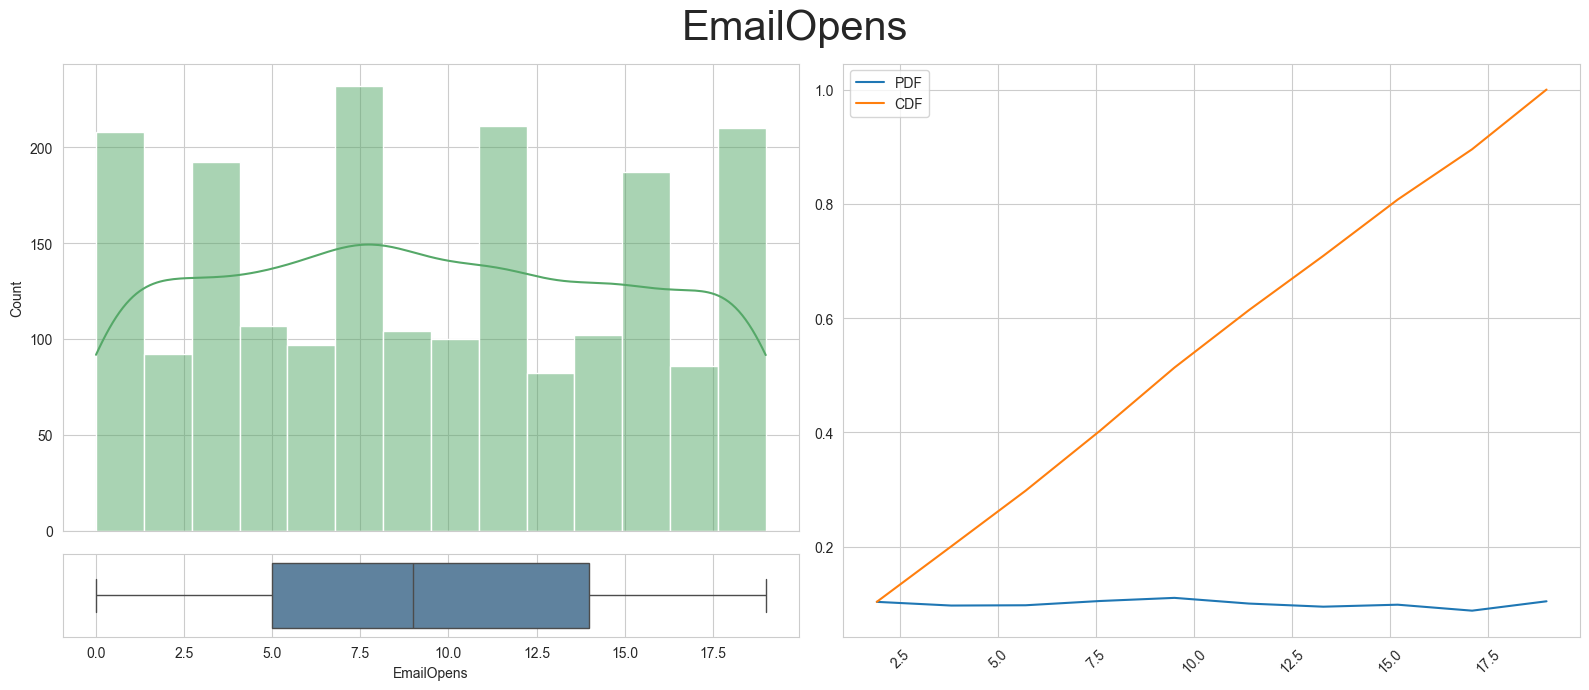

================== EmailOpens ==================
                             
count                  2010.0
mean                 9.410945
std                  5.740643
min                       0.0
25%                       5.0
50%                       9.0
75%                      14.0
max                      19.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.03556
type     right(positive)-skew


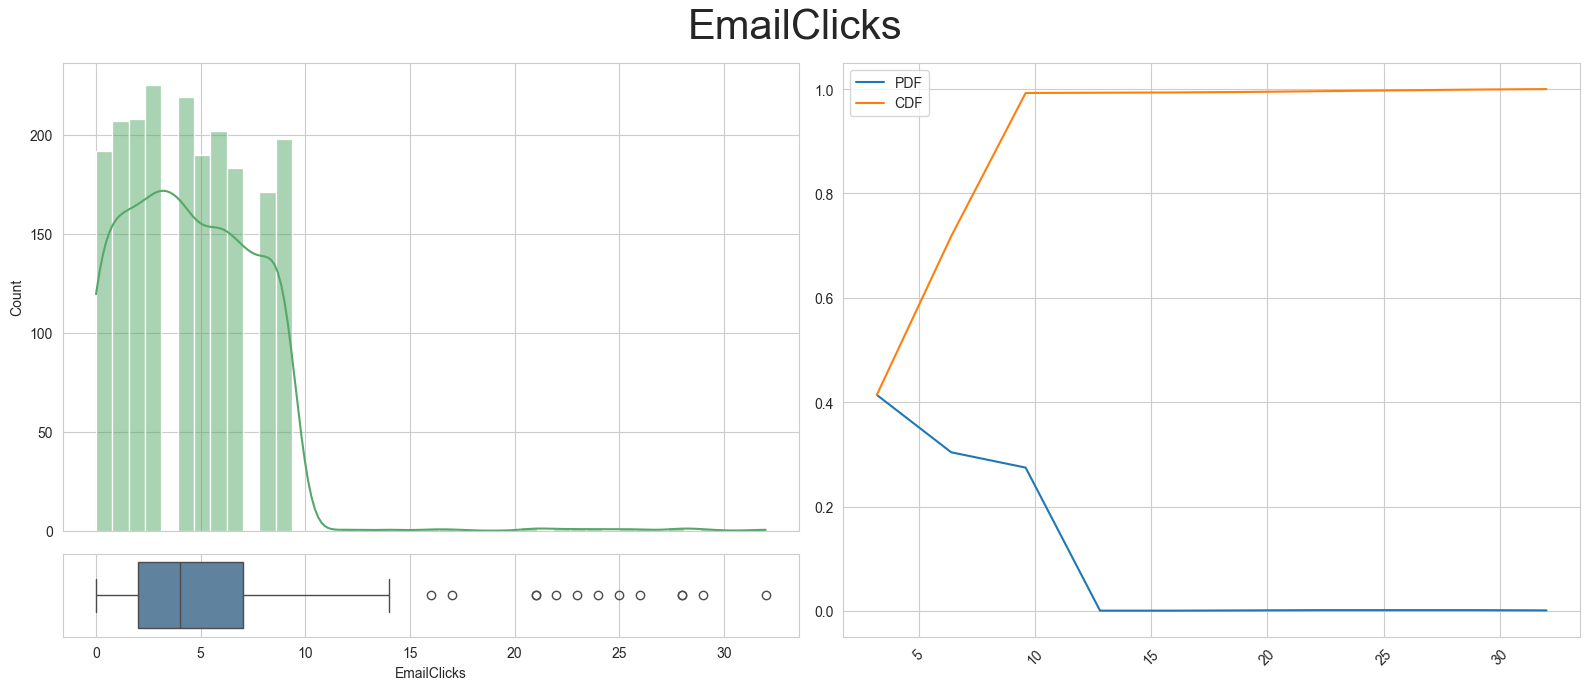

================== EmailClicks ==================
                             
count                  2010.0
mean                 4.529851
std                  3.262584
min                       0.0
25%                       2.0
50%                       4.0
75%                       7.0
max                      32.0
shapiro               0.00000
normal                  False
missing                     0
skew                  1.56944
type     right(positive)-skew


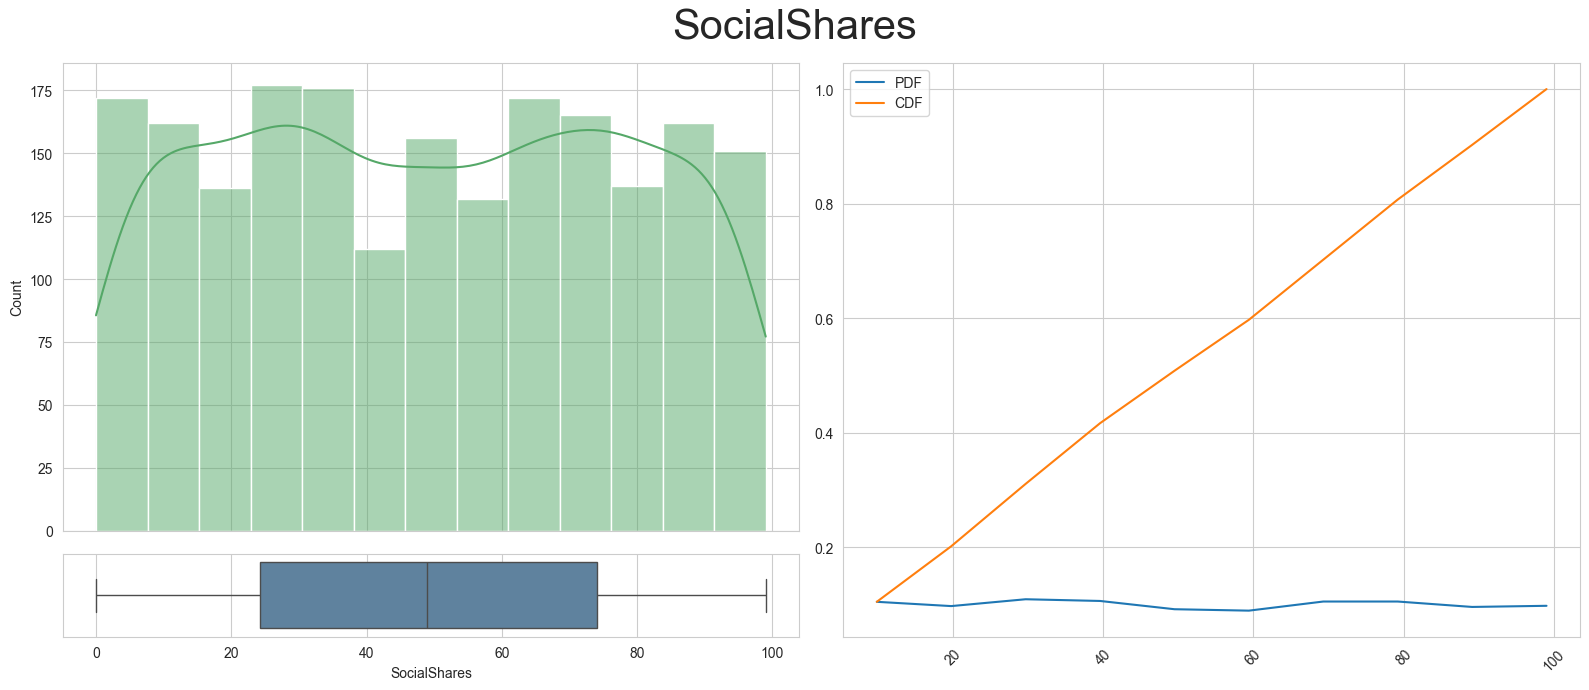

================== SocialShares ==================
                             
count                  2010.0
mean                49.002985
std                 28.960985
min                       0.0
25%                     24.25
50%                      49.0
75%                      74.0
max                      99.0
shapiro               0.00000
normal                  False
missing                     0
skew                  0.00676
type     right(positive)-skew


In [23]:
cols_to_analyze = ["EmailOpens", "EmailClicks", "SocialShares"]

for col in cols_to_analyze:
    describe_numerical_col(df, col)

# تحلیل رفتار کاربران بر اساس EmailOpens، EmailClicks و SocialShares

### 1️⃣ EmailOpens (تعداد باز شدن ایمیل‌ها)
- **آمار:**  
  تعداد داده‌ها: 2010  
  میانگین: 9.41  
  انحراف معیار: 5.74  
  کمترین/بیشترین: 0 – 19  
  میانه: 9  
  درصدها: 25% = 5، 50% = 9، 75% = 14  
- **ویژگی‌ها:**  
  داده‌ها **غیر نرمال** هستند (Shapiro-Wilk = 0.0)  
  توزیع تقریباً **متقارن** (Skewness = 0.036)  
- **تحلیل:**  
  اکثر کاربران بین 5 تا 14 بار ایمیل را باز کرده‌اند، برخی هیچ ایمیلی باز نکرده و برخی بسیار فعال هستند.  
- **دسته‌بندی پیشنهادی:**  
  - Very Low: 0–5  
  - Low: 5–10  
  - Medium: 10–15  
  - High: 15–20  
  - Very High: >20  

### 2️⃣ EmailClicks (تعداد کلیک‌ها روی ایمیل‌ها)
- **آمار:**  
  تعداد داده‌ها: 2010  
  میانگین: 4.53  
  انحراف معیار: 3.26  
  کمترین/بیشترین: 0 – 32  
  میانه: 4  
  درصدها: 25% = 2، 50% = 4، 75% = 7  
- **ویژگی‌ها:**  
  داده‌ها **غیر نرمال** هستند  
  توزیع **چپ‌کج به راست** (Skewness = 1.57) → بیشتر کاربران کلیک کمی داشته‌اند، برخی بسیار زیاد  
- **تحلیل:**  
  بیشتر کاربران بین 2 تا 7 بار کلیک کرده‌اند، تعداد زیادی هیچ کلیکی نداشته‌اند و تعداد محدودی کلیک زیادی داشته‌اند.  
- **دسته‌بندی پیشنهادی:**  
  - Very Low: 0–2  
  - Low: 2–4  
  - Medium: 4–7  
  - High: 7–10  
  - Very High: >10  

### 3️⃣ SocialShares (تعداد اشتراک‌گذاری‌ها در شبکه‌های اجتماعی)
- **آمار:**  
  تعداد داده‌ها: 2010  
  میانگین: 49  
  انحراف معیار: 28.96  
  کمترین/بیشترین: 0 – 99  
  میانه: 49  
  درصدها: 25% = 24.25، 50% = 49، 75% = 74  
- **ویژگی‌ها:**  
  داده‌ها **غیر نرمال** هستند  
  توزیع تقریباً **متقارن** (Skewness = 0.007)  
- **تحلیل:**  
  نیمی از کاربران بین 24 تا 74 بار محتوا را به اشتراک گذاشته‌اند، برخی هیچ اشتراکی نداشته و برخی بسیار فعال بوده‌اند.  
- **دسته‌بندی پیشنهادی:**  
  - Very Low: 0–25  
  - Low: 25–50  
  - Medium: 50–75  
  - High: 75–90  
  - Very High: >90  

### جمع‌بندی
- سه ستون **غیر نرمال** هستند، پس استفاده از روش‌های غیر پارامتریک یا دسته‌بندی مناسب برای تحلیل نسبت به ستون هدف `conversion` توصیه می‌شود.  
- دسته‌بندی‌ها به شکل **Very Low → Very High** تعریف شدند تا بتوان رفتار کاربران را بر اساس باز شدن ایمیل، کلیک و اشتراک‌گذاری تحلیل کرد.  
- با این دسته‌بندی، می‌توان **رابطه هر گروه با conversion** را به صورت نمودار و جدول بررسی کرد و فهمید کدام گروه‌ها بیشترین احتمال تبدیل را دارند.


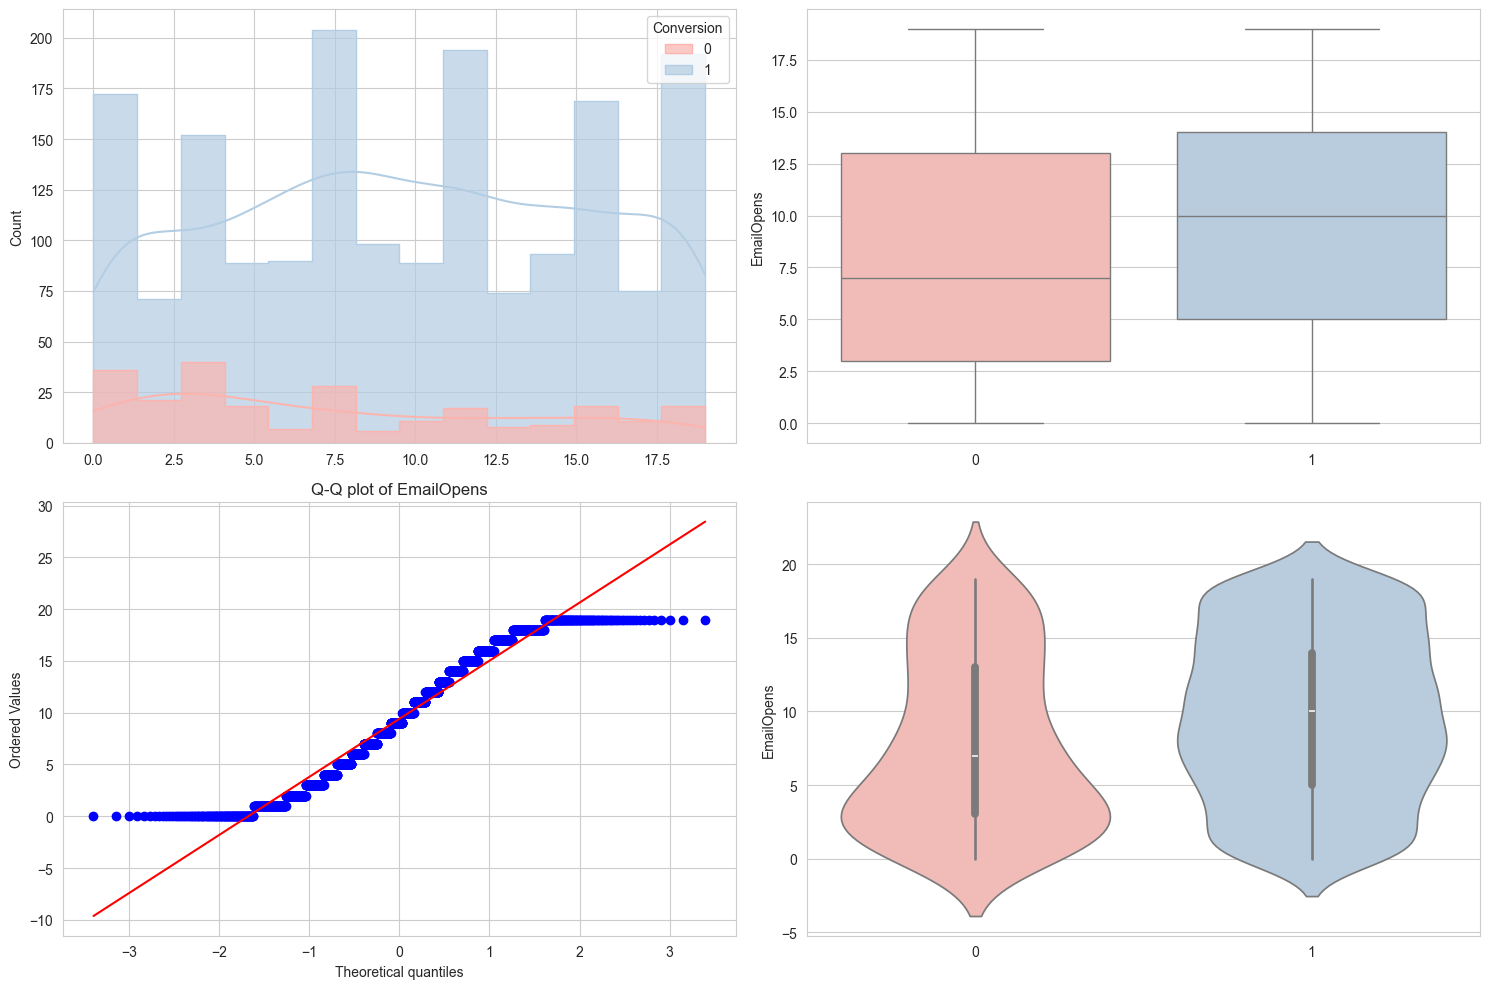


==================== خلاصه آماری EmailOpens بر اساس Conversion ====================
            count   mean  median    std  min  max   skew   kurt
Conversion                                                     
0             248  7.758     7.0  5.879    0   19  0.434 -1.109
1            1762  9.644    10.0  5.684    0   19 -0.014 -1.126


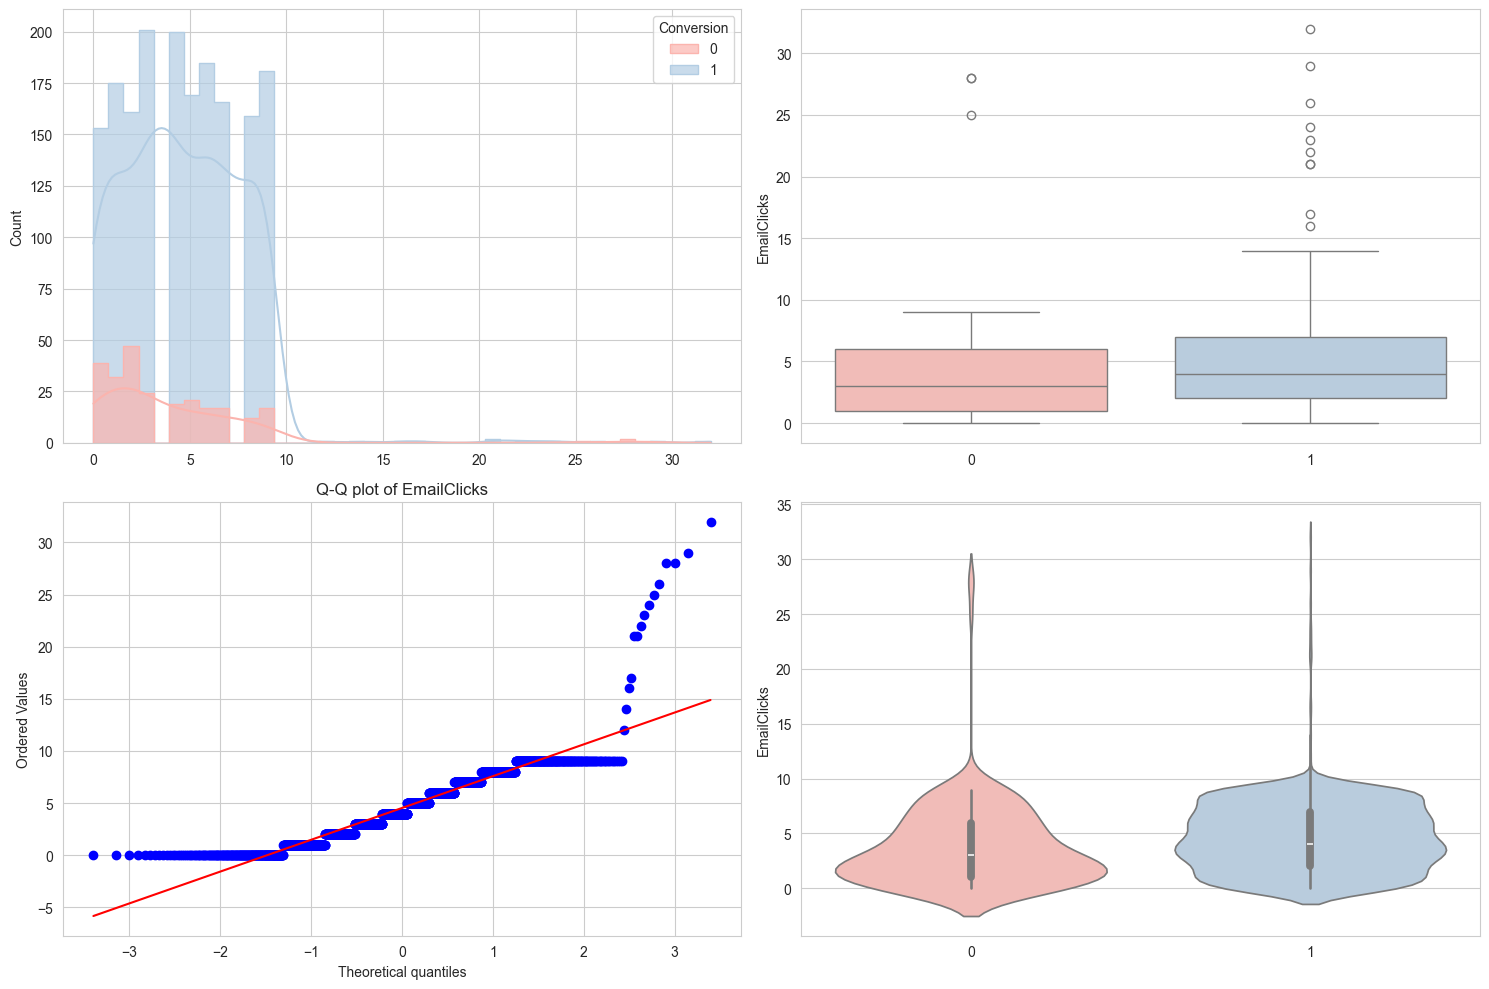


==================== خلاصه آماری EmailClicks بر اساس Conversion ====================
            count  mean  median    std  min  max   skew    kurt
Conversion                                                     
0             248  3.75     3.0  3.797    0   28  2.933  15.424
1            1762  4.64     4.0  3.166    0   32  1.304   7.554


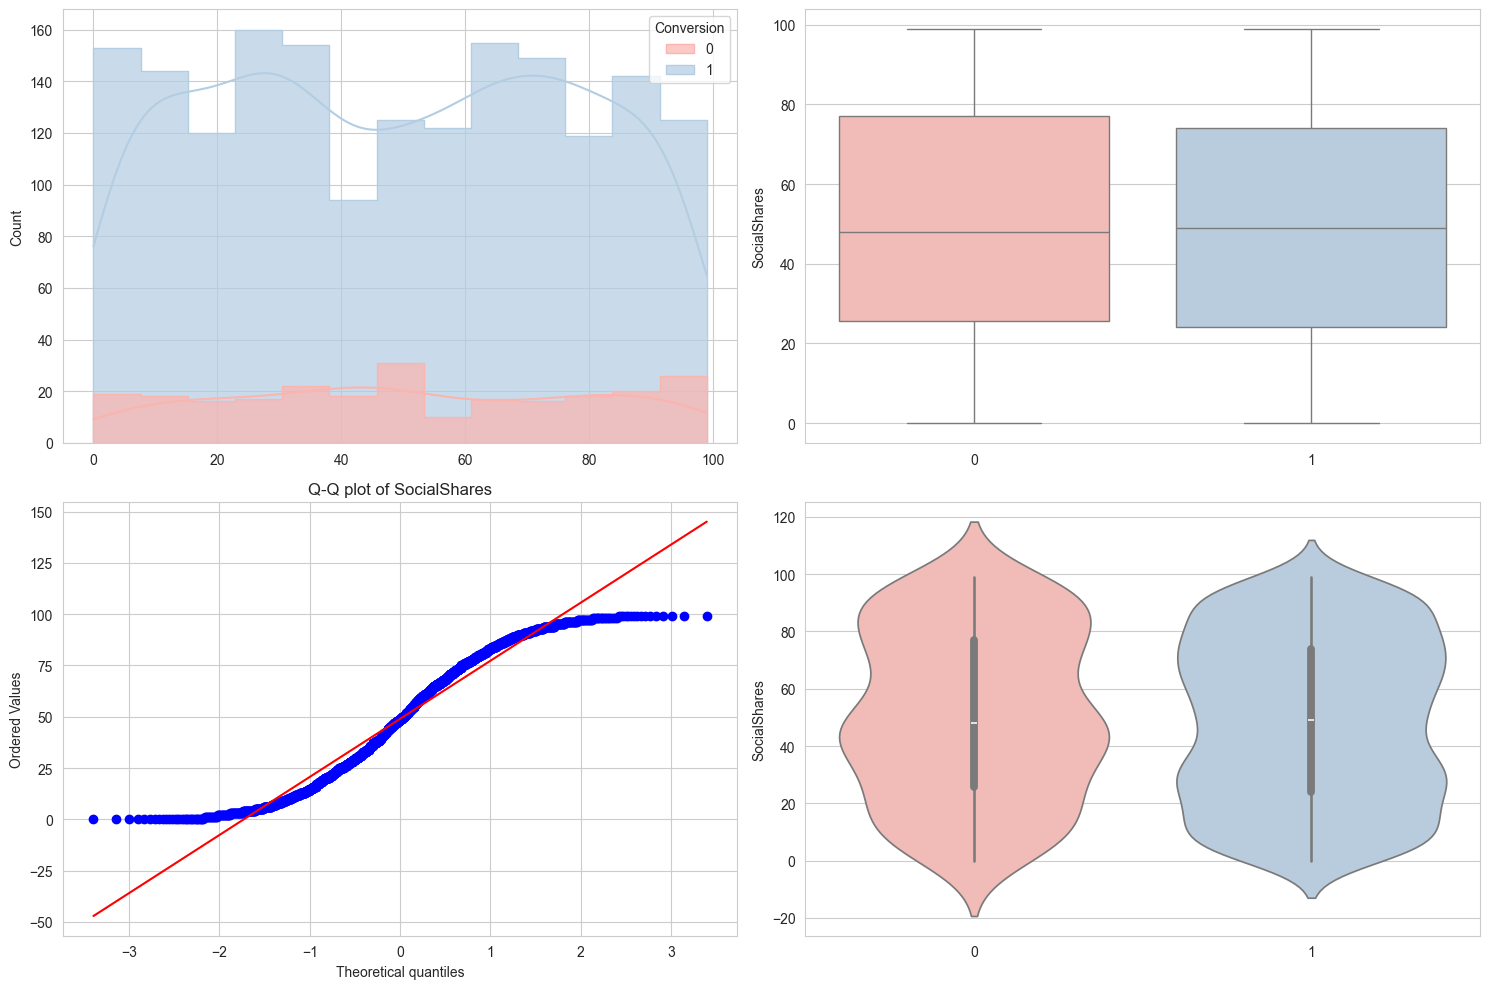


==================== خلاصه آماری SocialShares بر اساس Conversion ====================
            count    mean  median     std  min  max   skew   kurt
Conversion                                                       
0             248  50.710    48.0  29.162    0   99  0.004 -1.178
1            1762  48.763    49.0  28.933    0   99  0.007 -1.230


In [ ]:
num_cols = ["EmailOpens"]
target_col = "Conversion" 

for col in num_cols:
    plot_numerical_vs_target(df, col, target_col)


# تحلیل رفتار کاربران نسبت به Conversion

### 1️⃣ EmailOpens


- **تحلیل:**  
  کاربران تبدیل نشده (0) به طور متوسط ایمیل‌ها را کمتر باز کرده‌اند (میانگین 7.76) در حالی که کاربران تبدیل شده (1) میانگین بالاتری دارند (9.64).  
  توزیع در هر دو گروه تقریباً متقارن است، بنابراین افزایش تعداد باز شدن ایمیل‌ها با احتمال Conversion رابطه مثبت دارد.

---

### 2️⃣ EmailClicks
- **تحلیل:**  
  کاربران تبدیل شده تعداد کلیک بیشتری داشته‌اند (میانگین 4.64) نسبت به گروه 0 (میانگین 3.75).  
  توزیع کلیک‌ها **چپ‌کج به راست** است و برخی کاربران تعداد کلیک بسیار بالایی دارند، اما گروه تبدیل شده کلیک‌های بیشتری انجام داده است.  

---

### 3️⃣ SocialShares


- **تحلیل:**  
  تفاوت میانگین SocialShares بین گروه‌ها کم است (50.7 در گروه 0 و 48.8 در گروه 1).  
  توزیع تقریباً متقارن است و به نظر می‌رسد تعداد اشتراک‌گذاری‌ها تاثیر کمی بر Conversion داشته باشد.

---

### جمع‌بندی
- **EmailOpens و EmailClicks** بیشترین ارتباط را با Conversion دارند و افزایش آن‌ها احتمال تبدیل را بالا می‌برد.  
- **SocialShares** تفاوت چشمگیری بین گروه‌های تبدیل شده و نشده نشان نمی‌دهد.  
- توزیع داده‌ها غیر نرمال است و تحلیل‌ها باید با توجه به ویژگی‌های توزیع و استفاده از روش‌های دسته‌بندی یا غیر پارامتریک انجام شود.


=== تحلیل EmailOpens vs Conversion ===
EmailOpens نرمال است؟ خیر (p=0.000)
Conversion نرمال است؟ خیر (p=0.000)
همبستگی (Spearman): 0.109, p-value = 0.000


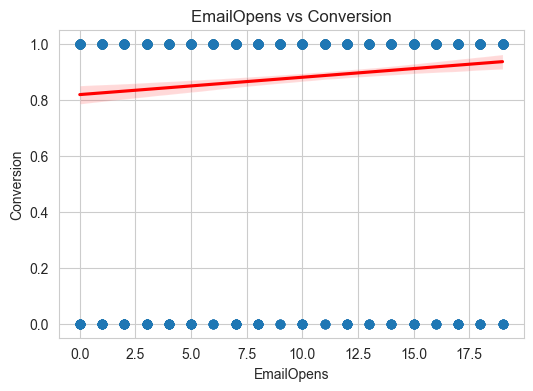

=== تحلیل EmailClicks vs Conversion ===
EmailClicks نرمال است؟ خیر (p=0.000)
Conversion نرمال است؟ خیر (p=0.000)
همبستگی (Spearman): 0.119, p-value = 0.000


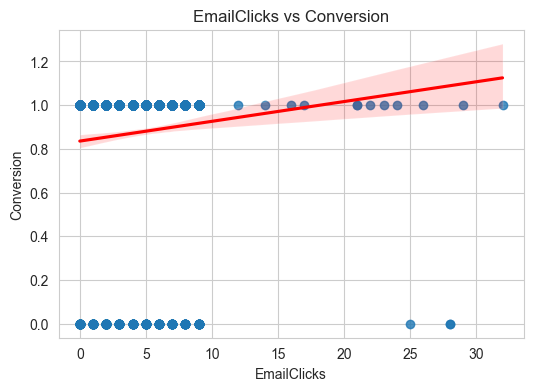

=== تحلیل SocialShares vs Conversion ===
SocialShares نرمال است؟ خیر (p=0.000)
Conversion نرمال است؟ خیر (p=0.000)
همبستگی (Spearman): -0.023, p-value = 0.312


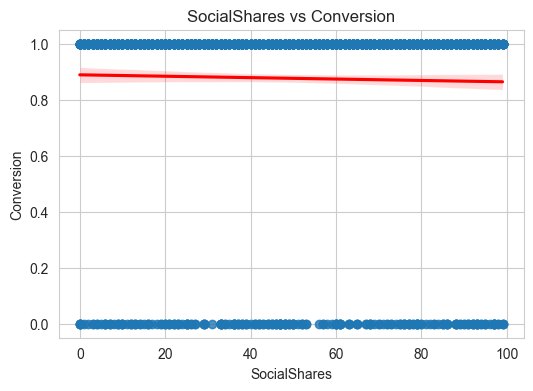

In [26]:
predictors = ["EmailOpens", "EmailClicks", "SocialShares"]
for col in predictors:
    bivariate_analysis(df, col)

In [41]:
bins = [0, 5, 10, 15, 20, float("inf")]
labels = ["Very Low", "Low", "Medium", "High", "Very High"]


num_cols = ["EmailOpens", "EmailClicks", "SocialShares"]


for col in num_cols:
    df = categorize_numerical_col(df, col, bins, labels)


print(df.head()[["EmailOpens", "EmailOpens_categorized",
                 "EmailClicks", "EmailClicks_categorized",
                 "SocialShares", "SocialShares_categorized"]])


   EmailOpens EmailOpens_categorized  EmailClicks EmailClicks_categorized  \
0           3               Very Low            6                     Low   
1           0                    NaN            2                Very Low   
2           1               Very Low            3                Very Low   
3           3               Very Low            7                     Low   
4          16                   High            7                     Low   

   SocialShares SocialShares_categorized  
0             9                      Low  
1            33                Very High  
2            29                Very High  
3            72                Very High  
4            41                Very High  


In [42]:

cat_cols = [
    "EmailOpens_categorized",
    "EmailClicks_categorized",
    "SocialShares_categorized"
]


for col in cat_cols:
    describe_categorical_col(df, col)


================== EmailOpens_categorized ==================
       Group  Count      %
0        Low    533  27.99
1   Very Low    493  25.89
2     Medium    491  25.79
3       High    387  20.33
4  Very High      0   0.00
================== EmailClicks_categorized ==================
       Group  Count      %
0   Very Low   1049  57.70
1        Low    754  41.47
2  Very High     11   0.61
3     Medium      2   0.11
4       High      2   0.11
================== SocialShares_categorized ==================
       Group  Count      %
0  Very High   1576  79.60
1     Medium    105   5.30
2   Very Low    101   5.10
3       High    100   5.05
4        Low     98   4.95



# تحلیل دسته‌بندی‌های رفتار کاربران

### 1️⃣ EmailOpens (تعداد باز شدن ایمیل)

**تحلیل:**  
- بیشترین کاربران در دسته **Low و Very Low** هستند، یعنی اکثر کاربران ایمیل‌ها را کمتر باز کرده‌اند.  
- هیچ کاربری در دسته **Very High** وجود ندارد.  
- دسته‌بندی نشان می‌دهد که افزایش تعداد باز شدن ایمیل‌ها می‌تواند فرصت افزایش Conversion را بالا ببرد، اما تعداد کاربران در دسته‌های بالا کم است.

---

### 2️⃣ EmailClicks (تعداد کلیک روی ایمیل)

**تحلیل:**  
- اکثریت کاربران در دسته‌های **Very Low و Low** قرار دارند، یعنی بیشتر کاربران تعداد کمی کلیک داشته‌اند.  
- تعداد کاربران با کلیک بالا بسیار کم است (Medium، High و Very High)، بنابراین کلیک زیاد نادر است و می‌تواند یک شاخص مهم برای Conversion باشد.

---

### 3️⃣ SocialShares (تعداد اشتراک‌گذاری‌ها)

**تحلیل:**  
- بیشتر کاربران (حدود 80٪) در دسته **Very High** هستند، یعنی تعداد اشتراک‌گذاری‌ها بالا است.  
- تفاوت زیادی بین دسته‌ها وجود ندارد، بنابراین SocialShares احتمالاً تاثیر کمتری روی Conversion دارد، زیرا بیشتر کاربران در دسته بالای اشتراک‌گذاری هستند و تغییر زیادی بین گروه‌ها دیده نمی‌شود.

---

### جمع‌بندی کلی
- **EmailOpens و EmailClicks** بیشترین پراکندگی و ارتباط با رفتار کاربران را نشان می‌دهند و می‌توانند پیش‌بینی‌کننده‌های خوبی برای Conversion باشند.  
- **SocialShares** اکثر کاربران در دسته Very High دارد و اثر آن بر Conversion کمتر مشخص است.  
- دسته‌بندی‌ها می‌توانند برای تحلیل‌های بعدی مانند **ماتریس تبدیل یا پیش‌بینی رگرسیونی** استفاده شوند.


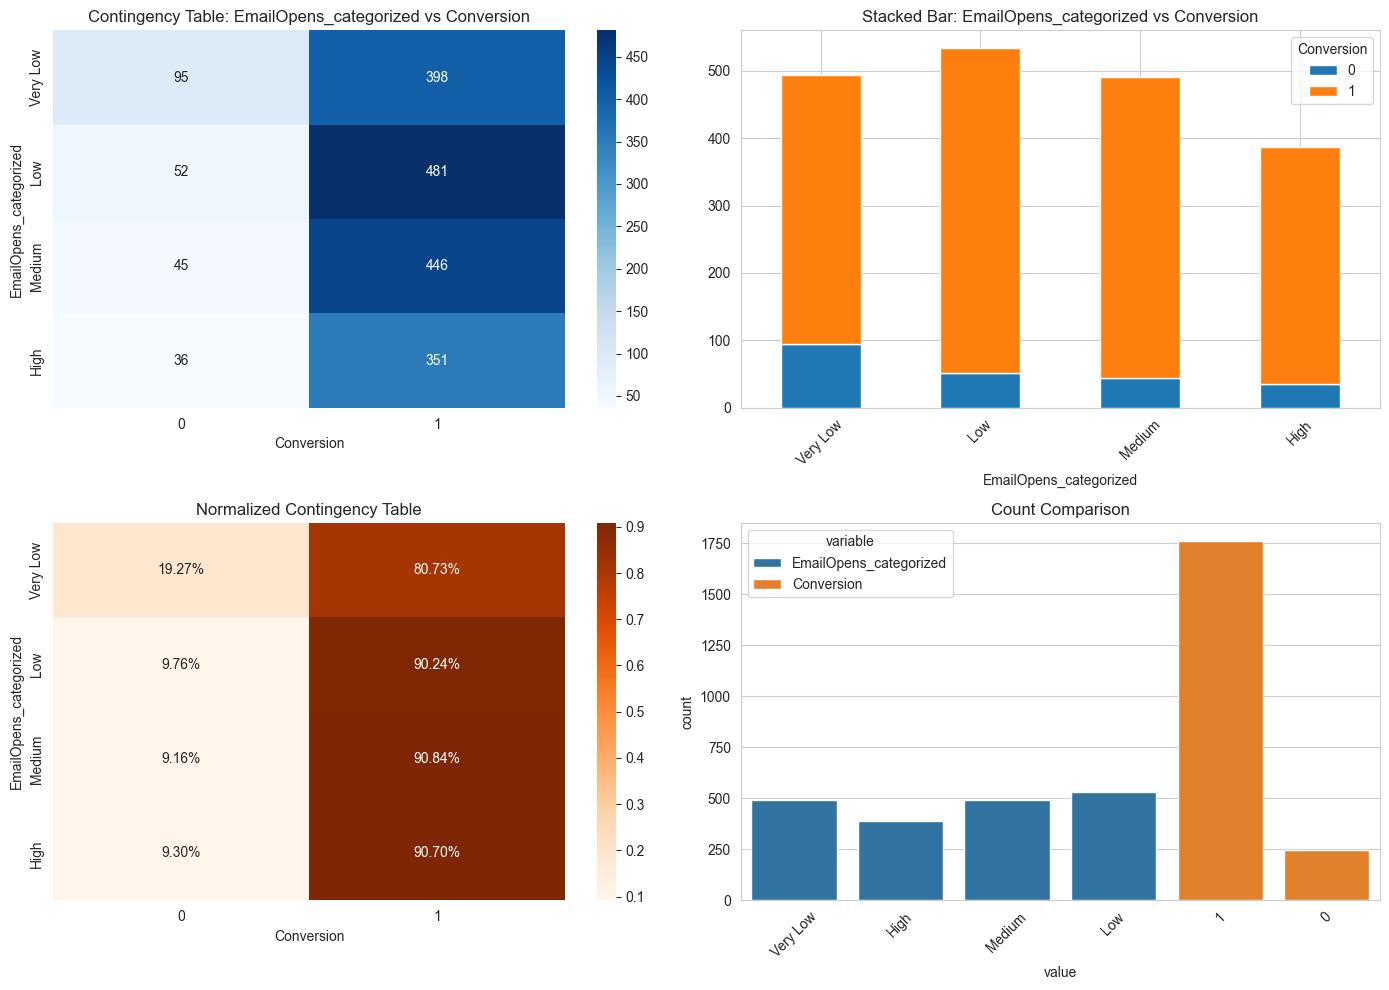

=============== EmailOpens_categorized vs Conversion ===============
Contingency Table:
Conversion               0    1
EmailOpens_categorized         
Very Low                95  398
Low                     52  481
Medium                  45  446
High                    36  351

Chi-square Test Results:
                                 
chi2_statistic           33.67866
p_value                   0.00000
degrees_of_freedom              3
cramers_v                 0.13300
association_strength     moderate
significant_association      True


In [45]:

describe_cat_cat_relationship(df, "EmailOpens_categorized", "Conversion")

### تحلیل
- **ارتباط معنی‌دار** بین دسته‌بندی EmailOpens و Conversion وجود دارد (p < 0.05).  
- شدت ارتباط **متوسط** است (Cramér's V = 0.133).  
- بیشترین تعداد Conversion=1 در دسته‌های **Low و Very Low** مشاهده می‌شود، که نشان می‌دهد حتی کاربرانی که ایمیل را کم باز کرده‌اند، احتمال Conversion دارند.  
- با این حال، دسته **High** نسبت Conversion بالایی دارد ولی تعداد کاربران در این دسته کمتر است.

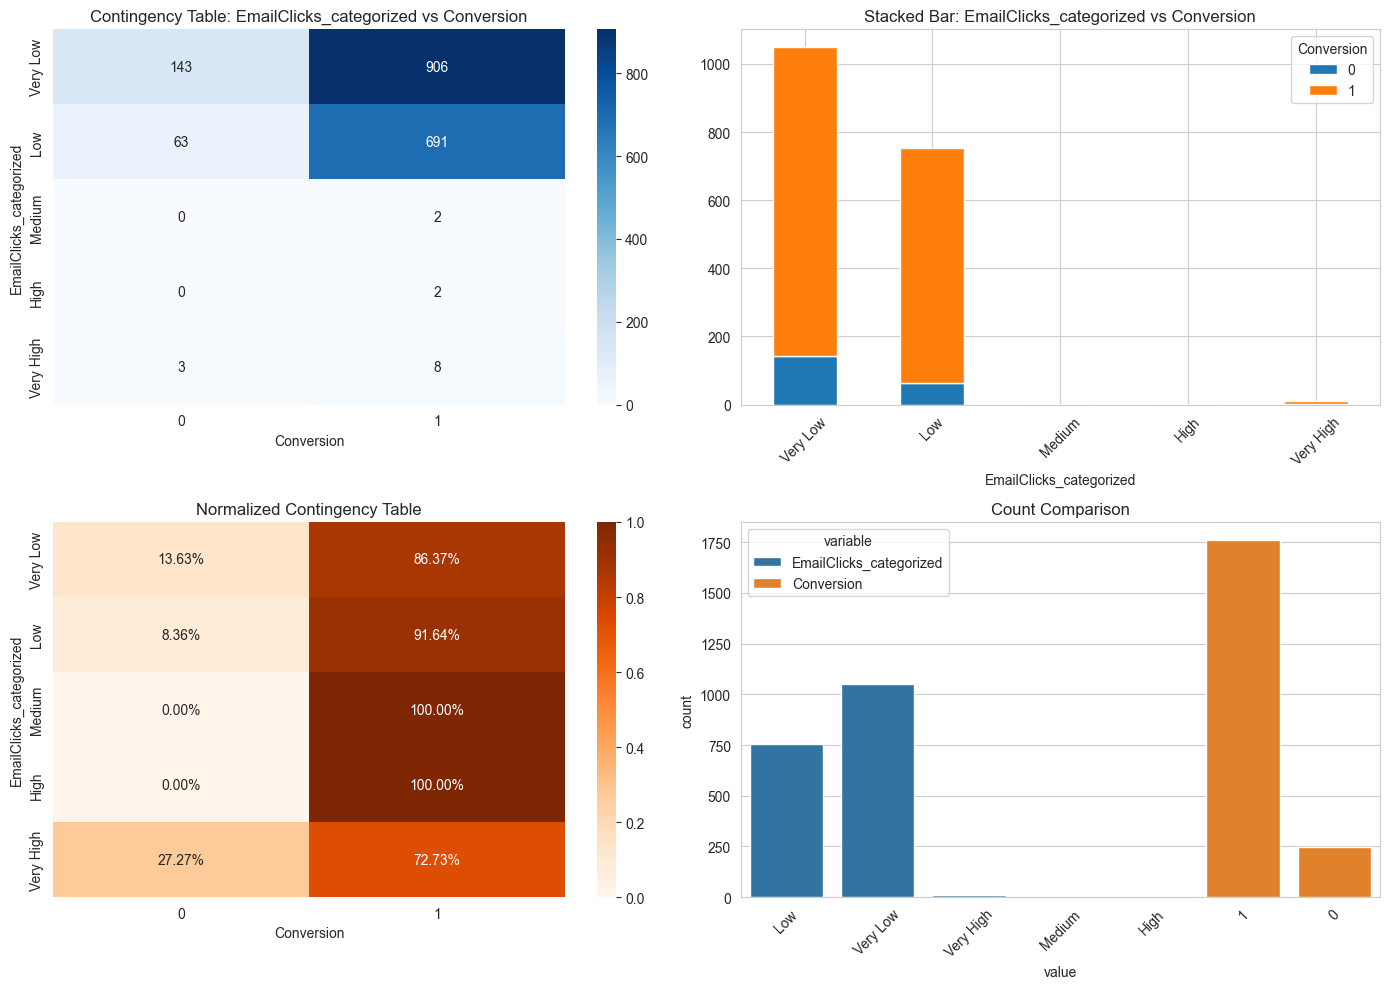

=============== EmailClicks_categorized vs Conversion ===============
Contingency Table:
Conversion                 0    1
EmailClicks_categorized          
Very Low                 143  906
Low                       63  691
Medium                     0    2
High                       0    2
Very High                  3    8

Chi-square Test Results:
                                 
chi2_statistic           15.22387
p_value                   0.00426
degrees_of_freedom              4
cramers_v                 0.09151
association_strength         weak
significant_association      True


In [46]:
describe_cat_cat_relationship(df, "EmailClicks_categorized", "Conversion")

### تحلیل
- **ارتباط معنی‌دار** بین دسته‌بندی EmailClicks و Conversion وجود دارد (p < 0.05).  
- شدت ارتباط **ضعیف** است (Cramér's V = 0.0915).  
- بیشترین تعداد Conversion=1 در دسته‌های **Very Low و Low** مشاهده می‌شود.  
- دسته‌های **Medium و High** تقریباً فاقد نمونه هستند، بنابراین تأثیر آن‌ها روی تحلیل محدود است.

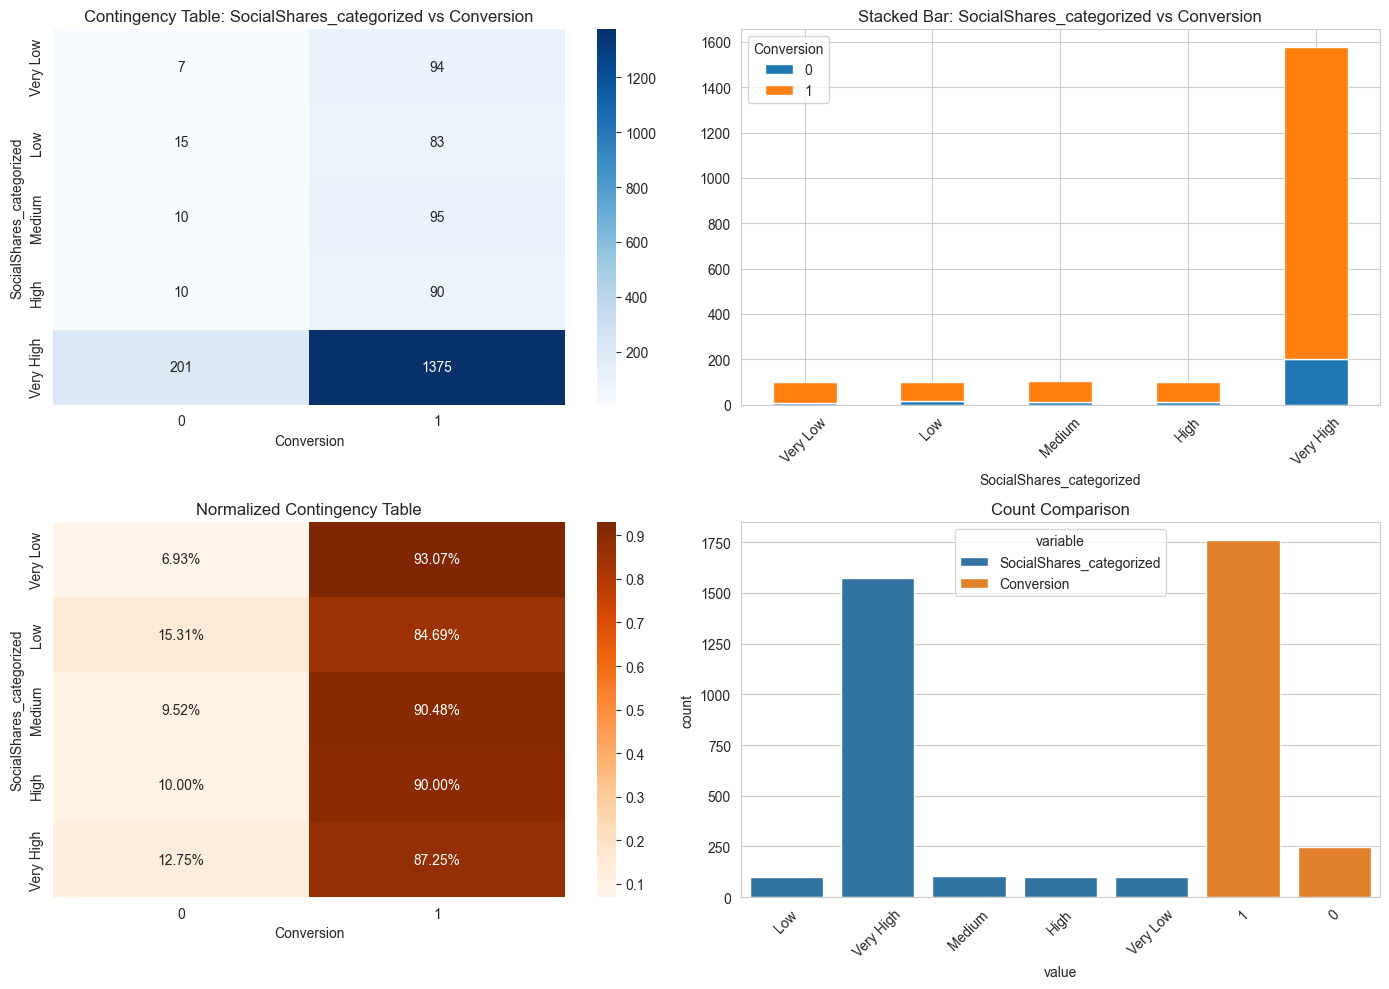

=============== SocialShares_categorized vs Conversion ===============
Contingency Table:
Conversion                  0     1
SocialShares_categorized           
Very Low                    7    94
Low                        15    83
Medium                     10    95
High                       10    90
Very High                 201  1375

Chi-square Test Results:
                                
chi2_statistic           5.07009
p_value                  0.28018
degrees_of_freedom             4
cramers_v                0.05060
association_strength        weak
significant_association    False


In [47]:
describe_cat_cat_relationship(df, "SocialShares_categorized", "Conversion")


### تحلیل
- **رابطه معنی‌دار** بین دسته‌بندی SocialShares و Conversion وجود ندارد (p > 0.05).  
- شدت ارتباط **ضعیف** است (Cramér's V = 0.0506).  
- بیشترین تعداد Conversion=1 در دسته **Very High** مشاهده می‌شود.  
- سایر دسته‌ها نسبتاً پراکنده هستند و تأثیر قابل توجهی روی Conversion ندارند.